# Watermark Detection in Images

## Packages

In [1]:
import os
import json
import time

from random import sample
from typing import Callable

import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms

from PIL import Image
from torchvision.ops import box_iou
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

## Path

In [2]:
IMG_DIR = "/kaggle/input/watermark-detection-in-images-dataset/images"
IMG_WATERMARKED_DIR = f"{IMG_DIR}/r123-watermark"
IMG_NON_WATERMARKED_DIR = f"{IMG_DIR}/non_watermark"
IMG_BB_DIR = "/kaggle/input/watermark-detection-in-images-bb/watermark-detection-in-image-bb.json"

OUTPUT_DIR = "/kaggle/working"
MODEL_DIR = f"{OUTPUT_DIR}/model"

if not os.path.isdir(MODEL_DIR):
    os.mkdir(MODEL_DIR)

## Parameters

In [3]:
IMAGE_SIZE = (800, 800)        # transform image size
NUM_WORKERS = 0                # number of subprocesses to use for data loading
BATCH_SIZE = 4                 # how many samples per batch to load

In [4]:
is_cuda_available = torch.cuda.is_available()

print('Train on GPU') if is_cuda_available else print('Train on CPU')

Train on GPU


## Dataset

### List Image Path

In [5]:
list_watermarked_image_path = [
    f"{IMG_WATERMARKED_DIR}/{filename}"
    for filename in os.listdir(IMG_WATERMARKED_DIR)
]

list_non_watermarked_image_path = [
    f"{IMG_NON_WATERMARKED_DIR}/{filename}"
    for filename in os.listdir(IMG_NON_WATERMARKED_DIR)
]

### Annotations Path

In [6]:
with open(IMG_BB_DIR, 'r') as file:
    img_annotations = json.load(file)
    
img_annotations.keys()

dict_keys(['images', 'categories', 'annotations', 'info'])

### Combine Watermarked Data with Annotations

In [7]:
# Metadata list (width, height, file_name, etc.)
metadata = img_annotations["images"]

# Bounding box and annotation information
annotations = img_annotations["annotations"]

# Extract image names (without the extension) from image paths
image_names = {path.split('/')[-1].split('.')[0]: path for path in list_watermarked_image_path}

# Combine the data
list_watermarked_image_path_with_bb = []
for meta in metadata:
    # Extract image name (without extension)
    image_name = meta['file_name'].split('/')[-1].split('.')[0].split('-')[1]
    # Find corresponding annotation
    annotation = next((ann for ann in annotations if ann['image_id'] == meta['id']), None)
    
    if annotation and image_name in image_names:
        list_watermarked_image_path_with_bb.append({
            'file_path': image_names[image_name],
            'bbox': annotation['bbox'],
            'segmentation': annotation['segmentation'],
            'ignore': annotation['ignore'],
            'is_crowd': annotation['iscrowd'],
            'area': annotation['area']
        })

### All Dataset Image Path

In [8]:
list_non_watermarked_image_path_with_bb = [{
        'file_path': img_path,
        'bbox': [],
        'segmentation': [],
        'ignore': 0,
        'is_crowd': 0,
        'area': 0.
    } for img_path in list_non_watermarked_image_path
]

list_image_file_path = list_watermarked_image_path_with_bb + list_non_watermarked_image_path_with_bb

len(list_watermarked_image_path_with_bb), len(list_non_watermarked_image_path_with_bb)

(42, 99)

### Dataset Transform

In [9]:
# Define augmentation for training
train_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# Define basic normalization for validation
val_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# Define basic normalization for test
test_transforms = transforms.Compose([
    transforms.ToTensor(),
])

### Dataset Class

In [10]:
torch.utils.data.Dataset

torch.utils.data.dataset.Dataset

In [11]:
from torchvision import transforms

class WatermarkDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, data_list: list, transform=None, target_size=IMAGE_SIZE):
        """
        Args:
            data_list (list): List of dictionaries containing image paths and annotations.
            transform (Callable, optional): Transformations to be applied to images.
            target_size (tuple, optional): Target size to resize images (width, height).
        """
        self.data_list = data_list
        self.target_size = target_size  # Desired size for resizing images

        # Define transformations, including resizing
        self.transform = transform if transform else transforms.ToTensor()

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        data_item = self.data_list[idx]
        img_path = data_item['file_path']
        bbox = data_item['bbox']  # Original bounding box
        
        # Load image and get original dimensions
        image = Image.open(img_path).convert("RGB")
        orig_width, orig_height = image.size

        # Resize the image to the target size
        resize_transform = transforms.Resize(self.target_size)
        image = resize_transform(image)
        new_width, new_height = self.target_size

        # Calculate the scaling factors for width and height
        x_scale = new_width / orig_width
        y_scale = new_height / orig_height

        # Resize the bounding box by applying the scaling factors
        if "r123-watermark" in img_path.lower():
            x_min, y_min, width, height = bbox
            
            # Adjust the bounding box according to the new image size
            x_min = x_min * x_scale
            y_min = y_min * y_scale
            width = width * x_scale
            height = height * y_scale

            x_max = x_min + width
            y_max = y_min + height

            # Ensure bounding box is valid
            if width <= 0 or height <= 0:
                raise ValueError(f"Invalid bounding box after resizing: {bbox}")

            # Create the target dictionary
            target = {
                'boxes': torch.tensor([[x_min, y_min, x_max, y_max]], dtype=torch.float32),  # Bounding box
                'labels': torch.tensor([1], dtype=torch.int64)  # Label for watermark
            }
        else:
            # No watermark case: empty bbox and label 0
            target = {
                'boxes': torch.empty((0, 4), dtype=torch.float32),  # No bounding box
                'labels': torch.tensor([0], dtype=torch.int64)  # Label for no watermark
            }

        # Apply any additional transforms (e.g., normalization)
        image = self.transform(image)

        return image, target


In [12]:
# Custom collate function to handle list of dictionaries and variable-sized tensors
def collate_fn(batch):
    images = [item[0] for item in batch]  # list of images
    targets = [item[1] for item in batch]  # list of target dictionaries
    return images, targets  # Keep them as lists without stacking

### Split Data and DataLoader

In [13]:
# Create the full dataset first (no transform yet)
full_dataset = WatermarkDetectionDataset(
    data_list=list_image_file_path
)

# Define sizes for each set (70% train, 15% validation, 15% test)
test_size = int(0.15 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
train_size = len(full_dataset) - val_size - test_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size]
)

# Now, re-assign the transforms to the training, validation, and test sets
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms
test_dataset.dataset.transform = test_transforms  # Ensure you define test_transforms if needed

# Data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
)


### Image Viewer

In [14]:
def imshow(img) -> None:
    img_transpose = np.transpose(img, (1, 2, 0))  # Convert to (H, W, C) for plotting
    plt.imshow(img_transpose)

def draw_bounding_boxes(ax, boxes, labels):
    if boxes.size == 0:  # Check if boxes are empty
        ax.set_title('0')
        return

    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = box  # Coordinates from the bounding box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.set_title(f"Label: {label.item()}")

def image_view(data_loader, target_size=IMAGE_SIZE, is_train=True):
    dataiter = iter(data_loader)
    if is_train:
        images, targets = next(dataiter)
    else:
        images = next(dataiter)

    fig = plt.figure(figsize=(25, 5))
    for idx in np.arange(min(20, len(images))):  # Ensure you don't exceed the available images
        ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
        imshow(images[idx])

        if is_train:
            # Get the bounding boxes and labels
            boxes = targets[idx]['boxes'].cpu().numpy() if targets[idx]['boxes'].size(0) > 0 else np.array([])  # Move boxes to CPU and convert to numpy
            labels = targets[idx]['labels'].cpu() if targets[idx]['boxes'].size(0) > 0 else torch.tensor([])  # Move labels to CPU

            # Get the original size from the image tensor (assume shape is [3, H, W])
            original_height, original_width = images[idx].shape[1:]

            # Scale the bounding boxes according to the new image size (target_size)
            height_scale = target_size[1] / original_height
            width_scale = target_size[0] / original_width

            # Adjust bounding boxes to match resized image
            resized_boxes = boxes.copy()
            if len(resized_boxes) > 0:
                resized_boxes[:, 0] *= width_scale  # Scale x_min
                resized_boxes[:, 1] *= height_scale  # Scale y_min
                resized_boxes[:, 2] *= width_scale  # Scale x_max
                resized_boxes[:, 3] *= height_scale  # Scale y_max

            draw_bounding_boxes(ax, resized_boxes, labels)

    plt.show()

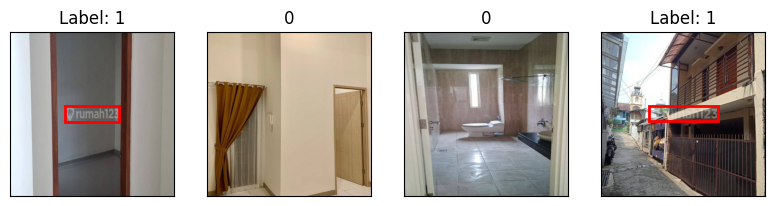

In [15]:
image_view(train_loader)

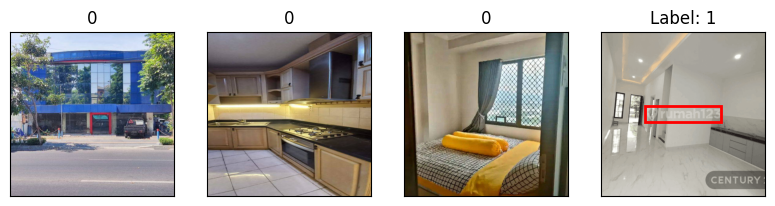

In [16]:
image_view(val_loader)

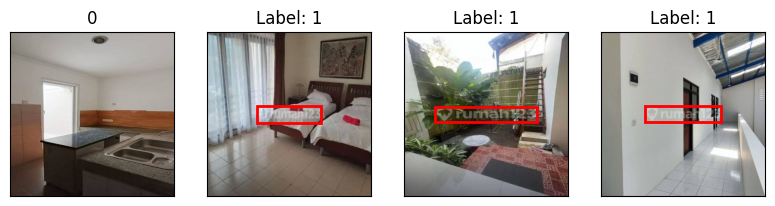

In [17]:
image_view(test_loader)

## Model

### Faster R-CNN

In [18]:
# Load the pre-trained Faster R-CNN model with a ResNet-50 backbone
model = fasterrcnn_resnet50_fpn(weights="FasterRCNN_ResNet50_FPN_Weights.DEFAULT")

# Freeze the layers in the backbone
for param in model.backbone.parameters():
    param.requires_grad = False

# Get the input features of the model's classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new head for binary classification (1 class + background)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)

# Move the model to GPU if available
if is_cuda_available:
    model.cuda()

### Training

In [19]:
n_epochs = 30
max_valid_iou = -np.inf
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Compute the class weight ratio for the positive class
class_weight_ratio = len(list_non_watermarked_image_path) / len(list_watermarked_image_path)

# Use this in your loss function
pos_weight = torch.Tensor([class_weight_ratio])

if is_cuda_available:
    pos_weight = pos_weight.cuda()

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [20]:
def compute_iou(boxes1, boxes2):
    """Compute the Intersection over Union (IoU) between two sets of boxes."""
    device = torch.device('cuda' if is_cuda_available else 'cpu')

    if boxes1.numel() == 0 or boxes2.numel() == 0:
        return torch.zeros(0).to(device)  # Ensure it's on the correct device
    return box_iou(boxes1, boxes2)

def compute_metrics(pred_boxes, pred_labels, true_boxes, true_labels, image_size=IMAGE_SIZE, iou_threshold=0.5):
    """Compute classification metrics: TP, TN, FP, FN, Precision, Recall, F1 Score."""
    TP, FP, FN, TN = 0, 0, 0, 0  # Initialize the metrics

    # Ensure pred_boxes and true_boxes are on the CPU
    pred_boxes = pred_boxes.cpu()
    true_boxes = true_boxes.cpu()

    # Case 1: No predicted boxes and no true boxes
    if len(pred_boxes) == 0 and len(true_boxes) == 0:
        # Entire image is considered background, so it's a True Negative
        TN += image_size[0] * image_size[1]  # Use the entire image size for TN
        return TP, TN, FP, FN, 0, 0, 0  # Precision, recall, and f1 score are 0 in this case

    # Case 2: No predicted boxes but true boxes exist
    if len(pred_boxes) == 0 and len(true_boxes) > 0:
        FN += len(true_boxes)  # All true boxes are false negatives
        return TP, TN, FP, FN, 0, 0, 0

    # Case 3: Predicted boxes exist but no true boxes
    if len(pred_boxes) > 0 and len(true_boxes) == 0:
        FP += len(pred_boxes)  # All predicted boxes are false positives
        return TP, TN, FP, FN, 0, 0, 0

    # Case 4: Both predicted and true boxes exist
    if len(pred_boxes) > 0 and len(true_boxes) > 0:
        ious = compute_iou(pred_boxes, true_boxes)  # Compute IoU for all box pairs

        # Initialize arrays to keep track of matched boxes
        pred_matched = torch.zeros(len(pred_boxes), dtype=torch.bool)
        true_matched = torch.zeros(len(true_boxes), dtype=torch.bool)

        # Loop over predicted boxes and match them to true boxes based on IoU threshold
        for pred_idx, pred_box in enumerate(pred_boxes):
            iou_values = ious[pred_idx]  # IoUs for this predicted box with all true boxes
            best_iou, best_true_idx = torch.max(iou_values, dim=0)  # Find the best IoU and corresponding true box

            if best_iou >= iou_threshold and not true_matched[best_true_idx]:
                # If the IoU is greater than the threshold and the true box is not already matched
                TP += 1
                pred_matched[pred_idx] = True  # Mark this predicted box as matched
                true_matched[best_true_idx] = True  # Mark this true box as matched

        # False Positives: Predicted boxes that didn't match any true box
        FP += (~pred_matched).sum().item()

        # False Negatives: True boxes that didn't match any predicted box
        FN += (~true_matched).sum().item()

    # Calculate Precision, Recall, and F1-Score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return TP, TN, FP, FN, precision, recall, f1_score


def compute_map_and_iou(model, data_loader, iou_threshold=0.5, is_cuda_available=False):
    model.eval()  # Set model to evaluation mode
    all_detections = []
    all_targets = []
    iou_list = []
    ap_list = []

    TP_total, TN_total, FP_total, FN_total = 0, 0, 0, 0

    device = torch.device('cuda' if is_cuda_available else 'cpu')

    with torch.no_grad():  # Disable gradient calculation for validation
        for imgs, targets in data_loader:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(imgs)  # Get model predictions
            for i, output in enumerate(outputs):
                pred_boxes = output['boxes']
                pred_labels = output['labels']
                true_boxes = targets[i]['boxes']
                true_labels = targets[i]['labels']

                # Calculate IoU for each image
                iou = compute_iou(pred_boxes, true_boxes)
                iou_list.append(iou)

                # Update classification metrics
                TP, TN, FP, FN, precision, recall, f1_score = compute_metrics(
                    pred_boxes=pred_boxes,
                    pred_labels=pred_labels,
                    true_boxes=true_boxes,
                    true_labels=true_labels,
                    iou_threshold=iou_threshold
                )

                TP_total += TP
                FP_total += FP
                FN_total += FN

    # Concatenate and move IoUs to device before averaging
    avg_iou = torch.cat(iou_list).mean().item() if iou_list else 0.0

    # Calculate overall precision, recall, F1 Score
    precision = TP_total / (TP_total + FP_total) if (TP_total + FP_total) > 0 else 0
    recall = TP_total / (TP_total + FN_total) if (TP_total + FN_total) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return avg_iou, precision, recall, f1_score


for epoch in range(1, n_epochs + 1):
    train_loss = 0.0

    # Set the model to training mode
    model.train()
    for imgs, targets in train_loader:
        if is_cuda_available:
            imgs = [img.cuda() for img in imgs]
            targets = [{k: v.cuda() for k, v in t.items()} for t in targets]  # Move targets to GPU
        else:
            imgs = [img.cpu() for img in imgs]
            targets = [{k: v.cpu() for k, v in t.items()} for t in targets]

        optimizer.zero_grad()  # Reset gradients
        loss_dict = model(imgs, targets)  # Forward propagation, get losses as a dict
        loss = sum(loss_dict.values())  # Sum all the losses
        loss.backward()   # Backward propagation
        optimizer.step()  # Update weights
        
        train_loss += loss.item() * len(imgs)  # Accumulate training loss

    # Set the model to evaluation mode and compute IoU and metrics
    avg_iou, precision, recall, f1_score = compute_map_and_iou(model, val_loader, is_cuda_available=is_cuda_available)
    
    # Output IoU and metrics
    print(f'Epoch {epoch} - Avg IoU: {avg_iou:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}')

    # Compute average training loss
    train_loss /= len(train_loader.dataset)

    # Print training results
    print(f'Epoch: {epoch}. Train Loss: {train_loss:.4f}')

    # Save the model if IoU improves (optional)
    if avg_iou > max_valid_iou:
        print(f'Validation IoU improved. Saving model...')
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'faster_rcnn_resnet50.pt'))
        max_valid_iou = avg_iou
        
    print('-' * 100)

Epoch 1 - Avg IoU: nan, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Epoch: 1. Train Loss: 0.1322
----------------------------------------------------------------------------------------------------
Epoch 2 - Avg IoU: 0.2677, Precision: 0.0638, Recall: 0.3333, F1 Score: 0.1071
Epoch: 2. Train Loss: 0.0631
Validation IoU improved. Saving model...
----------------------------------------------------------------------------------------------------
Epoch 3 - Avg IoU: 0.3499, Precision: 0.0435, Recall: 0.7778, F1 Score: 0.0824
Epoch: 3. Train Loss: 0.0463
Validation IoU improved. Saving model...
----------------------------------------------------------------------------------------------------
Epoch 4 - Avg IoU: 0.3371, Precision: 0.0526, Recall: 1.0000, F1 Score: 0.1000
Epoch: 4. Train Loss: 0.0369
----------------------------------------------------------------------------------------------------
Epoch 5 - Avg IoU: 0.3891, Precision: 0.0789, Recall: 1.0000, F1 Score: 0.1463
Epoch:

In [21]:
avg_iou, precision, recall, f1_score = compute_map_and_iou(model, test_loader, is_cuda_available=is_cuda_available)

avg_iou, precision, recall, f1_score
print(f'Avg IoU: {avg_iou:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}')

Avg IoU: 0.4954, Precision: 0.3158, Recall: 0.8571, F1 Score: 0.4615


## Prediction

In [22]:
def load_image(image_path):
    """Reads and loads an image from a given path."""
    img = Image.open(image_path).convert("RGB")  # Convert to RGB format
    return img

def transform_image(img):
    """Transforms the image for input into the Faster R-CNN model."""
    transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),  # Converts the image to a PyTorch tensor
    ])
    return transform(img)

# 3. Load the trained Faster R-CNN model
def load_model(model_path, is_cuda_available):
    """Loads a pre-trained Faster R-CNN model from the given path."""
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    
    # Load the trained weights
    model.load_state_dict(torch.load(model_path, weights_only=True))
    
    # Move the model to GPU if available
    if is_cuda_available:
        model = model.cuda()

    model.eval()  # Set the model to evaluation mode
    return model

def predict(model, img, is_cuda_available):
    """Makes a prediction on the given image using the loaded model."""
    # Transform the image
    transformed_img = transform_image(img).unsqueeze(0)  # Add batch dimension

    # Move the image to GPU if available
    if is_cuda_available:
        transformed_img = transformed_img.cuda()

    # Perform prediction
    with torch.no_grad():  # Disable gradient calculation for inference
        predictions = model(transformed_img)
    
    return predictions

def display_image_with_boxes(img, boxes, labels, target_size=IMAGE_SIZE):
    """Display a single image with bounding boxes and labels."""
    
    # Convert PIL image to NumPy array if it's not already in that format
    if isinstance(img, Image.Image):  # Check if the image is a PIL Image
        original_image = img.copy()  # Keep a copy of the original image for box scaling
        img = np.array(img)
    
    # Resize the image
    img = Image.fromarray(img)  # Convert back to PIL for resizing
    img = img.resize(target_size, Image.LANCZOS)  # Resize image with anti-aliasing
    img = np.array(img)  # Convert back to NumPy array after resizing
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # Display the image
    ax.imshow(img)

    # Optionally resize bounding boxes if a target size is provided
    if target_size is not None:
        original_height, original_width = img.shape[:2]  # Get original image size (H, W)
        height_scale = target_size[1] / original_height
        width_scale = target_size[0] / original_width

        resized_boxes = boxes.cpu().clone()  # Move boxes to CPU and clone them
        if len(resized_boxes) > 0:
            resized_boxes[:, 0] *= width_scale  # Scale x_min
            resized_boxes[:, 1] *= height_scale  # Scale y_min
            resized_boxes[:, 2] *= width_scale  # Scale x_max
            resized_boxes[:, 3] *= height_scale  # Scale y_max
    else:
        resized_boxes = boxes

    # Draw bounding boxes on the image
    draw_bounding_boxes(ax, resized_boxes, labels)
    
    # Display the plot
    plt.show()

Image path: /kaggle/input/watermark-detection-in-images-dataset/images/r123-watermark/U8vo1BqT2xhkpGIP.jpg
Predictions: [{'boxes': tensor([[288.6833, 364.0878, 526.4332, 435.4583],
        [177.2477, 375.0497, 680.8572, 461.1819]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9467, 0.0561], device='cuda:0')}]


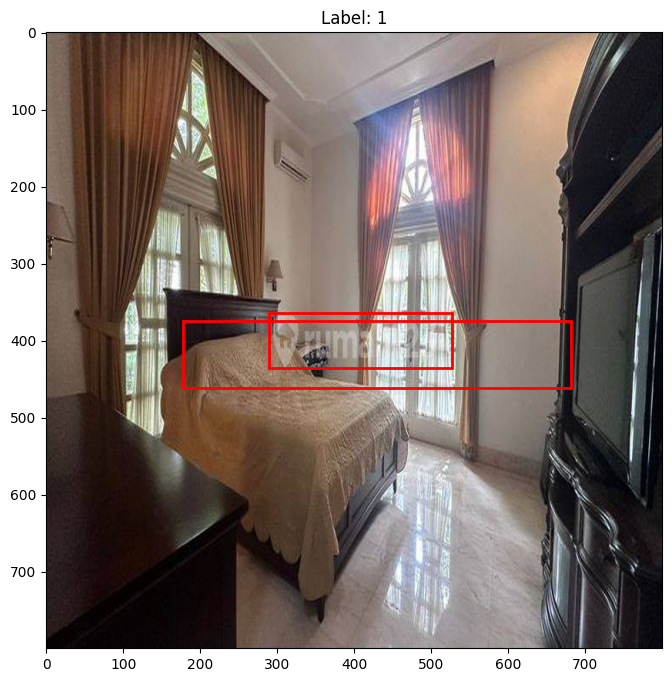

In [29]:
# image_path = sample(list_watermarked_image_path + list_non_watermarked_image_path, 1)[0]
image_path = sample(list_watermarked_image_path, 1)[0]
model_path = os.path.join(MODEL_DIR, 'faster_rcnn_resnet50.pt')

img = load_image(image_path)
model = load_model(model_path, is_cuda_available)
predictions = predict(model, img, is_cuda_available)

print(f"Image path: {image_path}\nPredictions: {predictions}")
display_image_with_boxes(img=img, boxes=predictions[0]['boxes'], labels=predictions[0]['labels'], target_size=IMAGE_SIZE)